In [284]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import visdom
import numpy as np
viz = visdom.Visdom(port=8097, server="127.0.0.1",env="gruAQI")
# line updates
loss_win = viz.line(np.arange(1))

In [285]:
df = pd.read_csv("./data/pm2.5.csv",encoding="utf-8")
df.head()

,日期,AQI,质量等级,PM2.5,PM10,SO2,CO,NO2,O3_8h
0,2018/5/29,114,轻度污染,0,0,18,0.8,61,154
1,2018/5/30,88,良,62,126,13,0.8,59,125
2,2018/5/31,90,良,34,60,11,0.6,34,148
3,2018/6/1,62,良,44,66,8,0.7,38,112
4,2018/6/2,75,良,54,78,9,1.0,47,98


In [293]:
#删除没有用的字段
del df["质量等级"]
#Z-Score标准换
features = df[["PM2.5","PM10","SO2","CO","NO2","O3_8h"]]
df[["PM2.5","PM10","SO2","CO","NO2","O3_8h"]] = (features-features.mean())/features.std()
df.head()

,日期,AQI,PM2.5,PM10,SO2,CO,NO2,O3_8h
0,2018/5/29,114,-1.766326,-1.879344,5.196942,-0.389461,1.361918,1.359118
1,2018/5/30,88,0.740471,1.513438,2.686342,-0.389461,1.211106,0.790299
2,2018/5/31,90,-0.391631,-0.263734,1.682102,-1.373363,-0.674047,1.241431
3,2018/6/1,62,0.012691,-0.102172,0.175742,-0.881412,-0.372422,0.535311
4,2018/6/2,75,0.417013,0.220950,0.677862,0.594441,0.306233,0.260709


In [294]:
df.count()

日期       360
AQI      360
PM2.5    360
PM10     360
SO2      360
CO       360
NO2      360
O3_8h    360
dtype: int64

In [295]:
df.describe()

,AQI,PM2.5,PM10,SO2,CO,NO2,O3_8h
count,360.000000,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02,3.600000e+02
mean,78.522222,-3.863615e-17,7.617364e-17,-2.221988e-15,-1.347687e-16,1.770189e-16,-5.674473e-17
std,31.177800,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,27.000000,-1.766326e+00,-1.879344e+00,-2.334858e+00,-1.865314e+00,-2.182169e+00,-1.484977e+00
25%,55.000000,-7.555209e-01,-7.214899e-01,-8.284979e-01,-8.814120e-01,-7.494528e-01,-7.788570e-01
50%,72.000000,-1.692538e-01,-1.290993e-01,1.757420e-01,1.024898e-01,-3.309490e-02,-2.394597e-01
75%,95.000000,4.978778e-01,6.046573e-01,6.778619e-01,5.944407e-01,6.832630e-01,6.726121e-01
max,205.000000,4.500667e+00,4.825441e+00,5.196942e+00,4.038097e+00,3.096258e+00,2.967502e+00


In [256]:
train_df= df[:300]
test_df = df[300:]

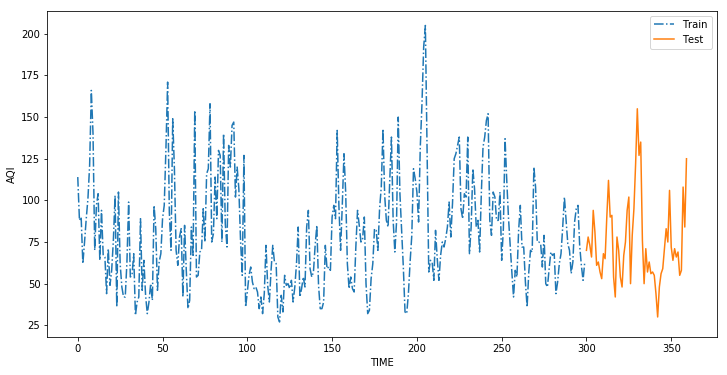

In [296]:
index = range(0,df.count()[0])
plt.figure(figsize=(12,6))
plt.ylabel("AQI")
plt.xlabel("TIME")
plt.plot(range(0,300),df["AQI"][:300],"-.")
plt.plot(range(300,360),df["AQI"][300:])
plt.legend(["Train","Test"])
plt.show()

### GRU

In [278]:
bins = 60            # RNN时间步长
input_dim = 6       # RNN输入尺寸
lr = 0.001            # 初始学习率
epochs = 1000        # 轮数
hidden_size=128       # 隐藏层神经元个数
num_layers = 2       # 神经元层数
bidirectional = True #双向循环
batch_size = 1

In [301]:
class GRUAQI(nn.Module):
    def __init__(self,input_dim,hidden_size,num_layers,bidirectional,power):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(hidden_size*power,1)

    def forward(self, x, h):
        r_out, h_state = self.gru(x,h)
        outs = [] 
        for record in range(r_out.size(1)):
            out = self.out(r_out[:, record, :])            
            outs.append(out)
        return torch.stack(outs, dim=1), h_state

In [303]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#if bidirectional=True 
power = 2 if(bidirectional) else 1

gruAQI = GRUAQI(input_dim,hidden_size,num_layers,bidirectional,power).to(device)
optimizer = torch.optim.Adam(gruAQI.parameters(), lr=lr)
loss_func = nn.MSELoss()
    

c_state = torch.zeros(num_layers*power,batch_size,hidden_size).to(device)
global_step = 0
for step in range(epochs):
    windows = int(np.ceil(300/bins))
    for window in range(windows):
        steps = train_df[window*bins:(window+1)*bins]
        x = torch.from_numpy(steps[["PM2.5","PM10","SO2","CO","NO2","O3_8h"]].values).unsqueeze(1).float().to(device)#【bins，batch,input_size=6】(50,1,6)
        y = torch.from_numpy(steps["AQI"].values).unsqueeze(1).unsqueeze(2).float().to(device)#【bins，batch,output=1】(50,1,1)
        prediction, c_state = gruAQI(x, c_state)  # RNN输出（预测结果，隐藏状态）
        #将每一次输出的中间状态传递下去(不带梯度)
        c_state = c_state.detach()  
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        if(global_step % 100 ==0):
            viz.line(Y=np.array([loss.item()]), X=np.array([global_step]), update='append', win=loss_win)
            print("loss:{:.8f}".format(loss))


loss:2906.59350586
loss:1468.35009766
loss:886.01312256
loss:698.11871338
loss:651.92736816
loss:373.77902222
loss:255.26251221
loss:171.51268005
loss:126.41258240
loss:104.35797882
loss:66.76502991
loss:50.48889923
loss:35.01764679
loss:26.25419235
loss:20.24172592
loss:12.82449436
loss:9.33254623
loss:6.53152990
loss:4.62014771
loss:11.05227470
loss:2.16092420
loss:1.67343104
loss:2.39896631
loss:0.30643886
loss:0.20736282
loss:2.25540638
loss:0.00893355
loss:0.00526767
loss:3.29036713
loss:0.02541628
loss:0.00141404
loss:0.00157296
loss:99.62470245
loss:1.05057847
loss:0.37584457
loss:0.40051508
loss:0.15700680
loss:0.20238453
loss:0.12375832
loss:0.13182293
loss:0.02103956
loss:0.38588652
loss:0.21055952
loss:0.11283959
loss:0.50159550
loss:1.24315464
loss:12.90230465
loss:0.01407368
loss:0.00390321
loss:0.00214102


In [304]:
def predict(model,input_data):
    length = input_data.count()[0]
    outs = []
    windows = int(np.ceil(length/bins))
    for window in range(windows):
        prediction, c_state = gruAQI(torch.from_numpy(input_data[["PM2.5","PM10","SO2","CO","NO2","O3_8h"]]
                              [window*bins:(window+1)*bins].values).unsqueeze(1).float().to(device),None)
        outs.extend(prediction.cpu().data.numpy().flatten())
    return outs

Test Loss:585.46099854


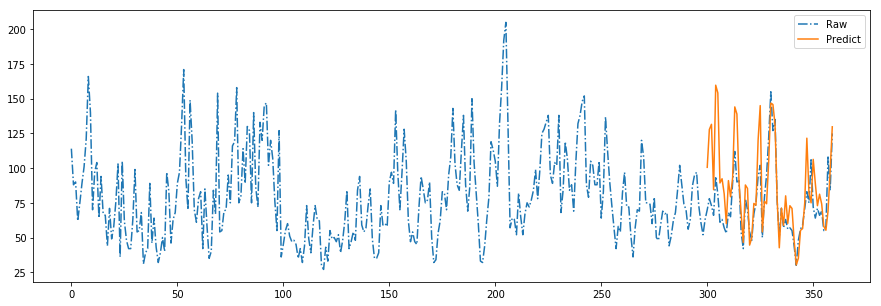

In [305]:
plt.figure(figsize=(15,5))
plt.plot(list(range(0,360)),df["AQI"].values,"-.")
plt.plot(list(range(300,360)),predict(gruAQI,test_df))
print("Test Loss:{:.8f}".format(loss_func(torch.FloatTensor(predict(gruAQI,test_df)), torch.from_numpy(test_df["AQI"].values).float())))
plt.legend(["Raw","Predict"])
plt.show()